# Report 3 - DBAHN trains-delays comparison

The objective of this notebook is to visualize the delays produced in a city in different hours of the day,  comparing:
- the number of trains 
- the maximum time registered in minutes of the delay

For this purpose the trajectories of 3 cities in Germany were captured from day 2019.07.19:
- Koblenz
- Bonn
- Köln

## Extension

### Multiple Plots
This notebook shows the process for 1 day in 1 city. It is possible to extend the functionalities and jointly represent several days and multiple cities.

### Extend Dataset
It would be interesting to add a third variable showing the evolution of other factors such as weather conditions: rain, temperature, etc..

In [1]:
# Imports
import sys
import os
import urllib, base64
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


## DATA

### Cities DBAHN ID
| eva Number  |  City Name |
|-------------|-------------|
| 8000044  | Bonn Hbf  |
| 8000206  | Koblenz Hbf  |
| 8000207  | Koeln Hbf  |

## Load content log file

In [2]:
# Define input files
datasetFolder = 'D:/PRO-CODE/dbahn-report/data/master/note-log-cleaner_station-travels/2019.07.19//'
datasetFolder_kaggle = '../input'

files = [
    '19.07.19_travels_Bonn.csv',
    '19.07.19_travels_Koblenz.csv',
    '19.07.19_travels_Koeln.csv',
]


In [3]:
def loadFile( _datasetFolder, _fileName ):
    fullPathFile = _datasetFolder + _fileName
    df = pd.read_csv( fullPathFile, engine='python', quoting=1, skip_blank_lines=True,
                     sep=",", quotechar='"',
                     encoding ='utf-8', dtype={'TSI': 'object'}
                    )
    return df.replace(np.nan, '', regex=True)

In [4]:
dfsDay = [
    loadFile( datasetFolder, files[0]),
    loadFile( datasetFolder, files[1]),
    loadFile( datasetFolder, files[2])
]

In [5]:
dfsDay[0].head(1)

,TAA,TA,TIN,TIR,TSI,TIM,TIL,TIRE,TIP,TIT,TID,TSC,TAc
0,,,RE 5(28503),Wesel 05:05-Dinslaken 05:16-Oberhausen-Holten ...,8000044,arr,/bin/traininfo.exe/dn/36201/392376/529130/2524...,Wesel,3,06:54,19.07.19,Bonn%238000044,0


# Select the index city

- 0: Bonn
- 1: Koblenz
- 2: Köln

In [6]:
# Select the index for the next steps
cityIndex = 2

# Init

In [7]:
# Extract City name and code
fullCityCode = dfsDay[ cityIndex ].iloc[0]['TSC']
cc = fullCityCode.split('%23')
cityCode = cc[1]
cityName = urllib.parse.unquote(cc[0])

cityCode, cityName

('8000207', 'Koeln')

In [8]:
# Extract report date
reportDate = '20' + dfsDay[ cityIndex ].iloc[0]['TID']
reportDayWeekNum =  dt.datetime.strptime( reportDate, '%Y.%m.%d').weekday() # 0 Monday - 6 Sunday
reportDayWeekName =  dt.datetime.strptime( reportDate, '%Y.%m.%d').strftime("%A")

reportDate, reportDayWeekNum, reportDayWeekName

('2019.07.19', 4, 'Friday')

### Base dataframes

In [9]:
'''
In older versions the delay (TA) was a int. Now is a hh:mm.
It´s necessary to calculate the delay in minutes (TAc)
'''
def calculateDelay( row ):
    delay = 0
    if row['TA'] is not '':
        taHour = dt.datetime.strptime( str(row['TA']), '%H:%M')
        titHour = dt.datetime.strptime( str(row['TIT']), '%H:%M')
        delay = divmod( ( taHour - titHour ).total_seconds() , 60)[0]  # delay in minutes
    return int(delay)

In [10]:
def extractDataColumns( _df ):
    _df['TAc'] = _df.apply( calculateDelay, axis=1 )
    dfSort = _df.sort_values(['TIT', 'TIN'], ascending=[1, 1])
    dfF = pd.concat( [
            dfSort['TIN'],
            dfSort['TAc'],
            dfSort['TIT'].apply( lambda t: 
                                int( dt.datetime.strptime( t, '%H:%M' ).strftime('%H') )
            )
        ], axis=1, keys=['train', 'delay', 'hour'] ) \
        .reset_index()
    return dfF


In [11]:
dfBaseSorted = [
    extractDataColumns(dfsDay[0]),
    extractDataColumns(dfsDay[1]),
    extractDataColumns(dfsDay[2])
]

dfBaseSorted[0].head(2)

,index,train,delay,hour
0,0,RE 5(28503),0,6
1,34,RE 5(28503),0,6


### Report data object

In [12]:
dfF = dfBaseSorted[ cityIndex ]

In [13]:
# Filter/exclude by train-type ?
dfF = dfF[ ~(dfF["train"].str.contains("S")) ]

In [14]:
g = dfF.groupby(['train','hour'])
#g.size()
#dfG = g.agg({'delay': ['min', lambda x: x.max(), 'max' ]})

dfFG = g.agg({'delay': ['max' ]})

dfFG.reset_index( inplace=True)
dfFG.columns = ['train','hour','delay_max']

In [15]:
dfFGS = dfFG.sort_values(['hour'], ascending=[1]).reset_index(drop=True)
dfFGS.head(5)

,train,hour,delay_max
0,ICE553,6,0
1,RB24(11405),6,0
2,RB27(12502),6,0
3,ICE101,6,0
4,RB26(25413),6,0


In [16]:
 f = {'train' : ['count'],
        'delay_max': np.count_nonzero,
        'delay_max' : np.max,
    }
dfFGSM = dfFGS.groupby('hour').agg(f)
dfFGSM.columns = ['train_count', 'delay_max_minutes']
dfFGSM

,train_count,delay_max_minutes
hour,,
6,6,0
7,49,49
8,43,15
9,42,42
10,41,28
11,5,35
12,41,32
13,41,90
14,44,17


In [17]:
dfFGSM180 = dfFGSM.transpose()
dfFGSM180

hour,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20
train_count,6,49,43,42,41,5,41,41,44,47,46,41,45,42,40
delay_max_minutes,0,49,15,42,28,35,32,90,17,89,58,114,60,57,66


# Plot

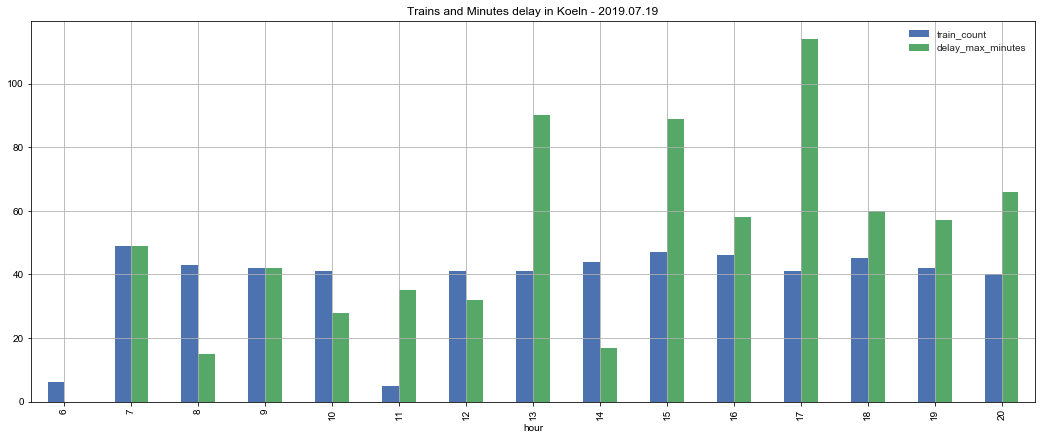

In [18]:
fig, ax = plt.subplots(figsize=(18,7))
plt.style.use('seaborn')
dfFGSM.plot(ax=ax, kind='bar')
plt.title('Trains and Minutes delay in ' + cityName + ' - ' + reportDate)
plt.show()

In [19]:
plotName = 'delays-03-cityhours__' + cityName + '-' + str(reportDate)
fig.savefig( 'D:/PRO-CODE/dbahn-report/project/reports//' + plotName + '.png', dpi=125)

### Output object

In [20]:
reportCityDateTrains = {
    'cityCode'  : cityCode,
    'cityName'  : cityName,
    'reportDate': reportDate,
    'reportDayWeek': reportDayWeekNum,
    'df' : dfFGSM180
}
reportCityDateTrains

{'cityCode': '8000207',
 'cityName': 'Koeln',
 'reportDate': '2019.07.19',
 'reportDayWeek': 4,
 'df': hour               6   7   8   9   10  11  12  13  14  15  16   17  18  19  20
 train_count         6  49  43  42  41   5  41  41  44  47  46   41  45  42  40
 delay_max_minutes   0  49  15  42  28  35  32  90  17  89  58  114  60  57  66}